In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
# --------------
# python imports
# --------------
import os,sys
import os.path as osp
import matplotlib
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from easydict import EasyDict as edict
import copy
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import axes3d, Axes3D 
import scipy.spatial.distance as scipy_d

# project imports
import _init_paths
import settings
from label_denoising import label_denoising as ld
from base.utils import *
from nn_knn.utils import *
import base.plot as base_plot
import base.thutils as thutils

In [6]:
settings.verbose = 1
cfg = load_mnist_cfg()
cfg.exp_name = "0ae3668d-2c94-448d-bd0d-d131123066e5"
data = edict()
data.tr,data.te,data.tr_sub = thutils.load_mnist_data(cfg)
data,labels = thutils.pytorch_datasetSubset_to_numpy(data.tr_sub)

4497fe07-069f-4d58-9254-0436b2c3611f


In [7]:
# load a single experiment's results
tr,te = load_results(cfg)

/home/gauenk/Documents/experiments/label_smoothing_sim/output/mnist_knn/0ae3668d-2c94-448d-bd0d-d131123066e5


## Plot the Similarity Matrix (Distance Matrix) for Neural Network trained on MNIST 

(10000, 128)
0.0 [0.8773214  0.8690607  0.82921141 0.8823227  0.89273475] [0.78103715 0.75892231 0.75255974 ... 0.74570573 0.74570573 0.74570573] 0.7083449932710518
1.0
0.8951267515963742 0.04068827645850151
0.7734068758607557 0.011642167400940203
(10000, 10000)


[]

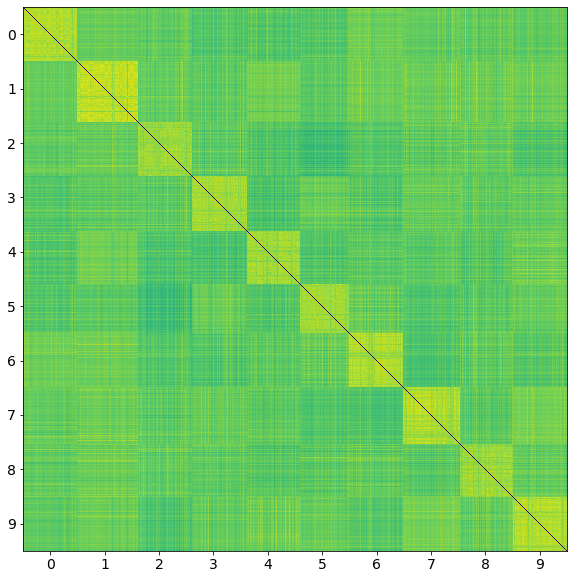

In [11]:
#
# Vizualize the similarity matrix
#
def construct_feature_image(ftrs):
    _labels = [str(cls) for cls in np.unique(labels)]
    print(ftrs.shape)
    sim_mat = scipy_d.pdist(ftrs)
    sim_mat /= sim_mat.max()
    K = np.exp( - sim_mat / 2.)
    #K = sim_mat
    img = scipy_d.squareform(K)
    return img
img = construct_feature_image(tr.features[-1])
print(img[0,0],img[0,5:10],img[0,1000:10004],img[0,5000])
print(img.max())
print(np.mean(img[0,0:1000]),np.std(img[0,0:1000]))
print(np.mean(img[0,1000:2000]),np.std(img[0,1000:2000]))
img /= img.max()
#img *= 255
#print(img.max())
fig, ax = plt.subplots(figsize=(10, 10))
print(img.shape)
ax.imshow(img, interpolation='none')
ax.set_xticks(np.arange(500,10000,1000,dtype=np.int))
ax.set_xticklabels(_labels,fontsize=14)
ax.set_yticks(np.arange(500,10000,1000,dtype=np.int))
ax.set_yticklabels(_labels,fontsize=14)
plt.plot()

## Show the distribution of distances from class 0 to class {0,1,2,3,4,5,6,7,8,9}

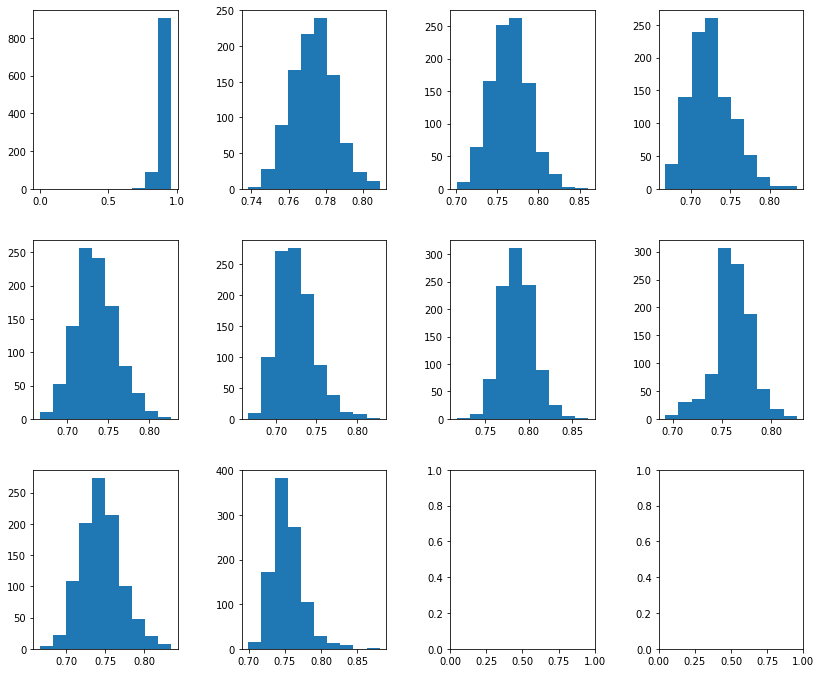

In [12]:
fig,ax = plt.subplots(3,4,figsize=(12,10))
fig.tight_layout(pad=3.0)
for i in range(10):
    j = i // 4
    k = i % 4
    start = i * 1000
    end = start + 1000
    ax[j][k].hist(img[0,start:end])

## Visualize how the Similarity Matrix Changes Over Epochs

In [13]:
#
# Vizualize the similarity matrix over iterations
#

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig,ax = plt.subplots(figsize=(8,8))
im = ax.imshow( npr.random( (10000,10000) ) )
ax_global = ax

# Initialization function: plot the background of each frame
def init():
    #im.set_data([])
    #sns.heatmap(np.zeros((nx, ny)), ax=ax_global)
    return im,

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    features = tr.features[i]
    sim_mat = scipy_d.pdist(features)
    sim_mat /= sim_mat.max()
    K = np.exp( - sim_mat / 2.)
    img = scipy_d.squareform(K)
    img /= img.max()
    ax.cla()
    im = ax.imshow(img)
    ax.set_title("Frame: " + str(i) +", Acc: {:.3f}".format(100*tr.acc[i]))
    return im,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=cfg.epochs, interval=500, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())


## Visualize a 2D projection of the Features (ued for the Similarity Matrix) over Epochs

In [15]:
#
# Visualize the Features Space on a 2-D projection
#

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display, Image
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize=(6,6))
ax = plt.axes(xlim=(0, 1), ylim=(-6, 10))
line2d, = ax.plot([], [], lw=1)
ax_global = ax
_labels = np.unique(labels)
base_plot.add_legend(ax,"Classes",_labels,shrink=True)


# Initialization function: plot the background of each frame
def init():
    line2d.set_data([], [])
    #sns.heatmap(np.zeros((nx, ny)), ax=ax_global)
    return line2d,

# Animation function which updates figure data.  This is called sequentially
def animate(i):
    features = tr.features[i]
    ax.cla()
    sns_ax = base_plot.proj2d(features,labels,ax=ax_global)
    ax.set_title("Frame: " + str(i) +", Acc: {:.3f}".format(100*tr.acc[i]))
    base_plot.add_legend(ax,"Classes",_labels,shrink=False)
    return line2d,

# Call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=cfg.epochs, interval=500, blit=True)

plt.close(anim._fig)

# Call function to display the animation
HTML(anim.to_html5_video())

# Visualize Several Final Results